In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)


/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sys.version_info(major=3, minor=11, micro=11, releaselevel='final', serial=0)
matplotlib 3.10.3
numpy 1.26.4
pandas 2.3.0
sklearn 1.7.0
torch 2.7.0+cu126
cuda:0


# MosesTokenizer预处理 subword-nmt分词

In [2]:
!pip install sacremoses subword-nmt

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [3]:
!sh data_multi30k.sh wmt16 wmt16 de en

[train] 源语言文本分词完成
[train] 目标语言文本分词完成
[val] 源语言文本分词完成
[val] 目标语言文本分词完成
[test] 源语言文本分词完成
[test] 目标语言文本分词完成
100%|####################################| 20000/20000 [00:21<00:00, 936.65it/s]
Finished applying bpe to train files.
Finished applying bpe to val files.
Finished applying bpe to test files.


In [4]:
!ls

01-classification-model.ipynb  spa.txt
checkpoints		       test_en_sentences.npy
data			       test_sp_sentences.npy
data_multi30k.py	       train_en_sentences.npy
data_multi30k.sh	       train_sp_sentences.npy
data_multi30k_es_en.py	       transformer_de_en_colab.ipynb
data_multi30k_es_en.sh	       transformer_es_en_colab.ipynb
seq2seq_attention_colab.ipynb  wmt16


Total sentences: 29000
Min length: 2
Max length: 47
Mean length: 13.03
Median length: 12.0


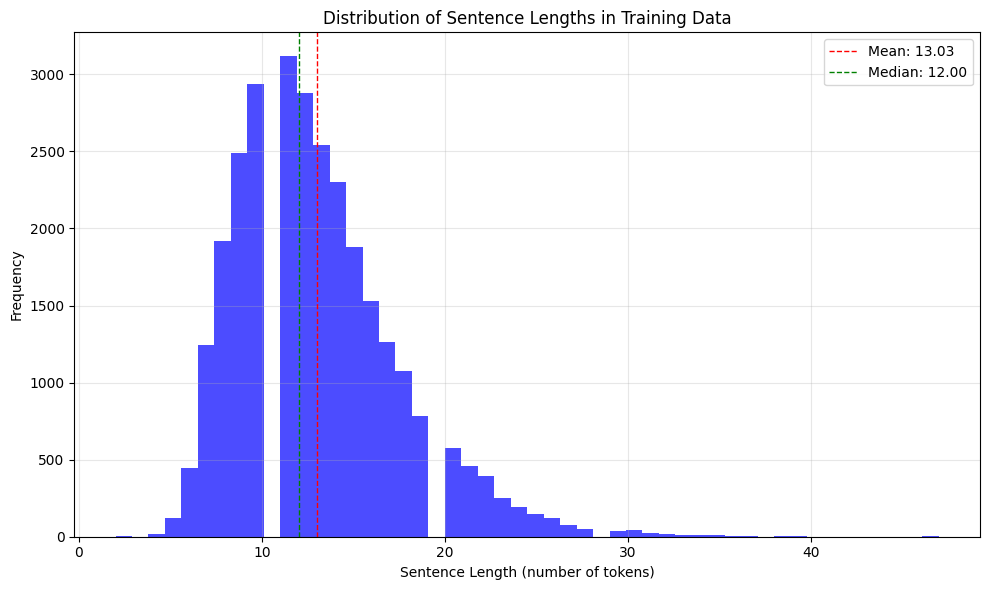

In [5]:
# Read the training source file and analyze sentence lengths
with open("wmt16/train_src.bpe", "r", encoding="utf8") as file:
    lines = file.readlines()

# Split each line and calculate lengths
lengths = [len(line.strip().split()) for line in lines]

# Create a histogram of sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, alpha=0.7, color='blue')
plt.xlabel('Sentence Length (number of tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths in Training Data')
plt.grid(True, alpha=0.3)

# Add some statistics as text
plt.axvline(np.mean(lengths), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(lengths):.2f}')
plt.axvline(np.median(lengths), color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(lengths):.2f}')
plt.legend()

# Display some statistics
print(f"Total sentences: {len(lengths)}")
print(f"Min length: {min(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"Mean length: {np.mean(lengths):.2f}")
print(f"Median length: {np.median(lengths)}")

plt.tight_layout()
plt.show()


Total sentences: 29000
Min length: 4
Max length: 41
Mean length: 13.25
Median length: 13.0


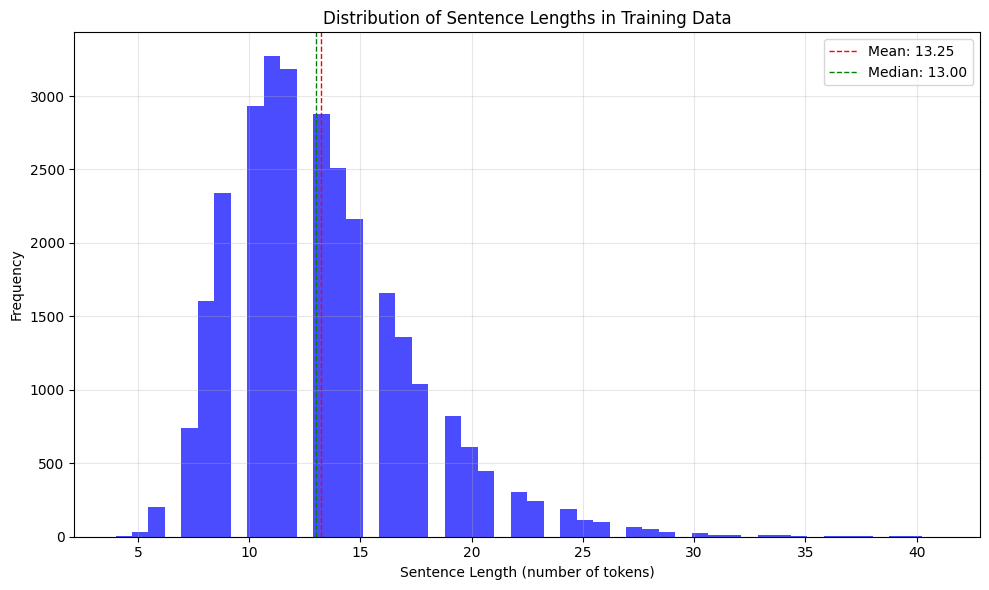

In [6]:
# Read the training source file and analyze sentence lengths
with open("wmt16/train_trg.bpe", "r", encoding="utf8") as file:
    lines = file.readlines()

# Split each line and calculate lengths
lengths = [len(line.strip().split()) for line in lines]

# Create a histogram of sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, alpha=0.7, color='blue')
plt.xlabel('Sentence Length (number of tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths in Training Data')
plt.grid(True, alpha=0.3)

# Add some statistics as text
plt.axvline(np.mean(lengths), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(lengths):.2f}')
plt.axvline(np.median(lengths), color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(lengths):.2f}')
plt.legend()

# Display some statistics
print(f"Total sentences: {len(lengths)}")
print(f"Min length: {min(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"Mean length: {np.mean(lengths):.2f}")
print(f"Median length: {np.median(lengths)}")

plt.tight_layout()
plt.show()


Total sentences: 29000
Min length: 16
Max length: 215
Mean length: 63.07
Median length: 60.0


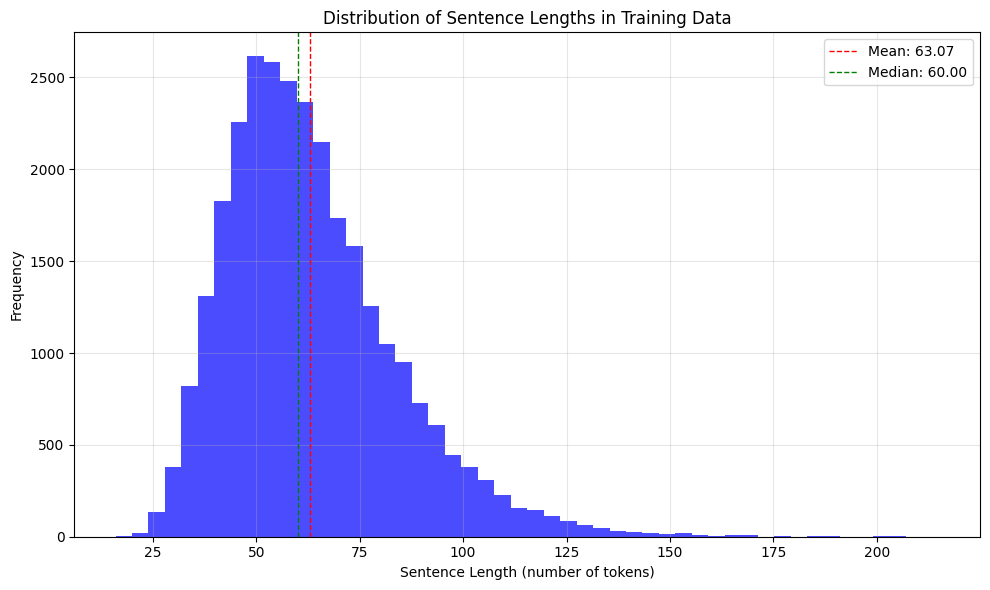

In [7]:
# Read the training source file and analyze sentence lengths
with open("wmt16/train_trg.bpe", "r", encoding="utf8") as file:
    lines = file.readlines()

# Split each line and calculate lengths
lengths = [len(line.strip()) for line in lines]

# Create a histogram of sentence lengths
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, alpha=0.7, color='blue')
plt.xlabel('Sentence Length (number of tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths in Training Data')
plt.grid(True, alpha=0.3)

# Add some statistics as text
plt.axvline(np.mean(lengths), color='r', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(lengths):.2f}')
plt.axvline(np.median(lengths), color='g', linestyle='dashed', linewidth=1, label=f'Median: {np.median(lengths):.2f}')
plt.legend()

# Display some statistics
print(f"Total sentences: {len(lengths)}")
print(f"Min length: {min(lengths)}")
print(f"Max length: {max(lengths)}")
print(f"Mean length: {np.mean(lengths):.2f}")
print(f"Median length: {np.median(lengths)}")

plt.tight_layout()
plt.show()


# LangPairDataset

In [8]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader



class LangPairDataset(Dataset):

    def __init__(
        self, mode="train", max_length=273, overwrite_cache=False, data_dir="wmt16",
    ):
        self.data_dir = Path(data_dir) #封装为path对象
        cache_path = self.data_dir / ".cache" / f"de2en_{mode}_{max_length}.npy" # 缓存路径

        if overwrite_cache or not cache_path.exists(): #判断是否需要覆盖缓存，或者缓存文件不存在
            cache_path.parent.mkdir(parents=True, exist_ok=True) # 创建缓存目录

            with open(self.data_dir / f"{mode}_src.bpe", "r", encoding="utf8") as file:
                self.src = file.readlines() # 读取源语言文件所有行

            with open(self.data_dir / f"{mode}_trg.bpe", "r", encoding="utf8") as file:
                self.trg = file.readlines() # 读取目标语言文件所有行

            filtered_src = []
            filtered_trg = []
            # max length filter,超出最大长度的句子舍弃
            for src, trg in zip(self.src, self.trg):
                if len(src) <= max_length and len(trg) <= max_length: # 过滤长度超过最大长度的句子
                    filtered_src.append(src.strip()) # 去掉句子前后的空格
                    filtered_trg.append(trg.strip())
            filtered_src = np.array(filtered_src)
            filtered_trg = np.array(filtered_trg)
            np.save(
                cache_path,
                {"src": filtered_src, "trg": filtered_trg },
                allow_pickle=True,
            )#allow_pickle=True允许保存对象数组，将过滤后的数据保存为 NumPy 数组，存储在缓存文件中
            print(f"save cache to {cache_path}")

        else:
            cache_dict = np.load(cache_path, allow_pickle=True).item() #allow_pickle=True允许保存对象数组
            print(f"load {mode} dataset from {cache_path}")
            filtered_src = cache_dict["src"]
            filtered_trg = cache_dict["trg"]

        self.src = filtered_src
        self.trg = filtered_trg

    def __getitem__(self, index):
        return self.src[index], self.trg[index]

    def __len__(self):
        return len(self.src)


train_ds = LangPairDataset("train")
val_ds = LangPairDataset("val")

load train dataset from wmt16/.cache/de2en_train_273.npy
load val dataset from wmt16/.cache/de2en_val_273.npy


In [9]:
len(train_ds)

101118

# Vocab词典

In [10]:
#载入词表，看下词表长度，词表就像英语字典,构建word2idx和idx2word
word2idx = {
    "[PAD]": 0,     # 填充 token
    "[BOS]": 1,     # begin of sentence
    "[UNK]": 2,     # 未知 token
    "[EOS]": 3,     # end of sentence
}
idx2word = {value: key for key, value in word2idx.items()}
index = len(idx2word)
threshold = 1  # 出现次数低于此的token舍弃

with open("wmt16/vocab", "r", encoding="utf8") as file:  # 打开词汇表文件进行读取，使用utf8编码
    for line in tqdm(file.readlines()):  # 使用tqdm显示进度条，遍历文件的每一行
        token, counts = line.strip().split()  # 去除每行两端的空白字符并按空格分割为token和出现次数
        if int(counts) >= threshold:  # 判断token的出现次数是否大于或等于阈值
            word2idx[token] = index  # 将token添加到word2idx字典，建立token到索引的映射
            idx2word[index] = token  # 将token添加到idx2word字典，建立索引到token的映射
            index += 1  # 索引值增加1，为下一个token准备

vocab_size = len(word2idx)  # 计算词表大小，即word2idx字典中的条目数量
print("vocab_size: {}".format(vocab_size))  # 打印词表大小


100%|██████████| 18107/18107 [00:00<00:00, 851215.10it/s]

vocab_size: 18111


# Tokenizer

In [11]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=128, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.max_length = max_length
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.unk_idx = unk_idx

    def encode(self, text_list, padding_first=False, add_bos=True, add_eos=True, return_mask=False):
        """如果padding_first == True，则padding加载前面，否则加载后面"""
        max_length = min(self.max_length, add_eos + add_bos + max([len(text) for text in text_list]))
        indices_list = []
        #text_list是句子列表，每个句子是一个单词列表,text_list是一个批次
        for text in text_list:
            indices = [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - add_bos - add_eos]]
            if add_bos:#如果add_bos == True，则添加[BOS]
                indices = [self.bos_idx] + indices
            if add_eos:#如果add_eos == True，则添加[EOS]
                indices = indices + [self.eos_idx]
            if padding_first:#如果padding_first == True，则padding加载前面，否则加载后面
                indices = [self.pad_idx] * (max_length - len(indices)) + indices
            else:
                indices = indices + [self.pad_idx] * (max_length - len(indices))
            indices_list.append(indices)
        input_ids = torch.tensor(indices_list)
        masks = (input_ids == self.pad_idx).to(dtype=torch.int64) # 为了方便损失计算，这里的mask为0的地方需要计算，为1的地方不需要计算
        return input_ids if not return_mask else (input_ids, masks)


    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        text_list = []
        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]")
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":
                    break
                if remove_pad and word == "[PAD]":
                    break
                text.append(word)
            text_list.append(" ".join(text) if not split else text) #如果split == True，则返回一个单词列表，否则返回一个句子
        return text_list #返回一个句子列表


tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word)


raw_text = ["hello world".split(), "a little boy playing gam@@ e@@ cu@@ be at a mcdonald &apos;s .".split(), "this is a test".split()]
indices = tokenizer.encode(raw_text, padding_first=False, add_bos=True, add_eos=True)
decode_text = tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)
print("raw text")
for raw in raw_text:
    print(raw)
print("indices")
for index in indices:
    print(index)
print("decode text")
for decode in decode_text:
    print(decode)

raw text
['hello', 'world']
['a', 'little', 'boy', 'playing', 'gam@@', 'e@@', 'cu@@', 'be', 'at', 'a', 'mcdonald', '&apos;s', '.']
['this', 'is', 'a', 'test']
indices
tensor([   1, 9458, 3522,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
tensor([   1,    5,  105,   56,   63, 8664,  732, 2716,  414,   35,    5, 4016,
         192,    4,    3])
tensor([   1,  385,   18,    5, 5699,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
decode text
[BOS] hello world [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[BOS] a little boy playing gam@@ e@@ cu@@ be at a mcdonald &apos;s . [EOS]
[BOS] this is a test [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [12]:
class SampleInfo: #下面的info对象
    def __init__(self, i, lens):
        """
        记录文本对的序号和长度信息
        输入：
            - i (int): 文本对的序号。
            - lens (list): 文本对源语言和目标语言的长度
        """
        self.i = i
        # 加一是考虑填补在文本前后的特殊词元，lens[0]和lens[1]分别表示源语言和目标语言的长度
        self.max_len = max(lens[0], lens[1]) + 1
        # self.max_len = lens[0] + 1
        self.src_len = lens[0] + 1
        self.trg_len = lens[1] + 1

# 一个批量生成器，根据词元数目的限制来控制批量的大小。它会根据传入的样本信息，在不超过设定大小的情况下，逐步构建批量。
#就是箱子
class TokenBatchCreator:
    def __init__(self, batch_size):
        """
        参数:
        batch_size (int): 用于限制批量的大小。箱子大小 高*宽
        功能:
        初始化了一个空的批量列表 _batch。
        设定了初始的最大长度为 -1。
        存储了传入的 batch_size。
        """

        self.__batch = []  #这个就是之前的batch_size，就是第一个batch内有多少个样本
        self.max_len = -1  #箱子内最长的样本长度
        self._batch_size = batch_size # 限制批量的大小,假设是4096

    def append(self, info: SampleInfo):
        """
        参数:
        info (SampleInfo): 文本对的信息。
        功能:
        接收一个 SampleInfo 对象，并根据其最大长度信息更新当前批量的最大长度。
        如果将新的样本加入批量后超过了批量大小限制，它会返回已有的批量并将新的样本加入新的批量。
        否则，它会更新最大长度并将样本添加到当前批量中。
        """
        # 更新当前批量的最大长度
        cur_len = info.max_len # 当前样本的长度
        max_len = max(self.max_len, cur_len) # 每来一个样本，更新当前批次的最大长度
        # 如果新的样本加入批量后超过大小限制，则将已有的批量返回，新的样本加入新的批量
        if max_len * (len(self.__batch) + 1) > self._batch_size:
            self.__batch, result = [], self.__batch # 保存当前的batch，并返回,这里的result是之前的batch,_batch清空
            self.__batch.append(info) #箱子里的第一条样本，放入
            self.max_len = cur_len #因为是当前batch的第一个样本，所以它的长度就是当前长度
            return result
        else:
            self.max_len = max_len
            self.__batch.append(info) # 将样本添加到当前批量中
            return None

    @property
    def batch(self):
        return self.__batch

In [13]:
# 当一个自定义对象可以iter(自定义对象)时，会自动调用__iter__方法
from torch.utils.data import BatchSampler
import numpy as np


class TransformerBatchSampler(BatchSampler):
    def __init__(self,
                 dataset,
                 batch_size,
                 shuffle_batch=False,
                 clip_last_batch=False,
                 seed=0):
        """
        批量采样器
        输入:
            - dataset: 数据集
            - batch_size: 批量大小
            - shuffle_batch: 是否对生成的批量进行洗牌
            - clip_last_batch: 是否裁剪最后剩下的数据
            - seed: 随机数种子
        """
        self._dataset = dataset #数据集
        self._batch_size = batch_size #箱子大小
        self._shuffle_batch = shuffle_batch #是否打乱箱子
        self._clip_last_batch = clip_last_batch #是否裁剪最后剩下的数据
        self._seed = seed #下面3个是为了随机
        self._random = np.random
        self._random.seed(seed)

        self._sample_infos = [] #所有样本信息
        # 根据数据集中的每个样本，创建了对应的 SampleInfo 对象，包含了样本的索引和长度信息。
        for i, data in enumerate(self._dataset):
            lens = [len(data[0]), len(data[1])] #输入和输出的长度计算放到lens中
            self._sample_infos.append(SampleInfo(i, lens)) #每个样本信息

    def __iter__(self):
        """
        对数据集中的样本进行排序，排序规则是先按源语言长度排序，如果相同则按目标语言长度排序。
        使用 TokenBatchCreator 逐步组装批量数据，当满足批量大小时返回一个批量的样本信息。
        如果不裁剪最后一个批次的数据且存在剩余样本，则将这些样本组成最后一个批次。
        如果需要对批量进行洗牌，则对批次进行洗牌操作。
        通过迭代器，抛出每个批量的样本在数据集中的索引。
        """
        # 排序，如果源语言长度相同则按照目标语言的长度排列
        infos = sorted(self._sample_infos,
                       key=lambda x: (x.src_len, x.trg_len))
        # 把样本放入到箱子里，所有装箱后的箱子，每一个箱子都放入batch_infos
        batch_infos = [] #放箱子的列表，每个箱子都是一个batch
        batch_creator = TokenBatchCreator(self._batch_size) # 批量生成器,上面自定义的类
        for info in infos:
            batch = batch_creator.append(info)
            # 存够一个batch的样本信息后，会把这个batch返回，否则返回为None
            if batch is not None:
                batch_infos.append(batch)

        # 是否抛弃最后批量的文本对
        if not self._clip_last_batch and len(batch_creator.batch) != 0:
            batch_infos.append(batch_creator.batch) # 最后一个batch

        # 打乱batch，打乱的是箱子的顺序
        if self._shuffle_batch:
            self._random.shuffle(batch_infos)

        self.batch_number = len(batch_infos) #箱子数量
        # print(self.batch_number) #为了理解

        # 抛出一个箱子里所有样本的序号
        for batch in batch_infos:
            batch_indices = [info.i for info in batch] # 批量的样本在数据集中的索引，第一个batch[0,1,.....82]，第二个batch[83,84,85,86,87]
            yield batch_indices

    def __len__(self):
        """
        返回批量的数量
        """
        if hasattr(self, "batch_number"):
            return self.batch_number
        # 计算批量的数量,没有用到下面的情况，不用看
        batch_number = (len(self._dataset) +
                        self._batch_size) // self._batch_size
        return batch_number

In [14]:
sampler = TransformerBatchSampler(train_ds, batch_size=4096, shuffle_batch=True)

#为什么这里每个批量的样本对数目不一样呢？长度*batch_number>4096的时候，就会返回上一个batch，然后新的样本加入新的batch,具体要看TokenBatchCreator的44行

In [15]:
for idx, batch in enumerate(sampler):
    print("第{}批量的数据中含有文本对是：{}，数量为：{}".format(idx, batch, len(batch)))
    if idx >= 3:
        break

第0批量的数据中含有文本对是：[31099, 31227, 31794, 31967, 32468, 32648, 32956, 32999, 33772, 35204, 35564, 35945, 35955, 36019, 36512, 38698, 39048, 39651, 39720, 40004, 40279, 42017, 42251, 42467, 43059, 44415, 45875, 45934, 46207, 47328, 48089, 49453, 50473, 50489, 50714, 51162, 51588, 53210, 53411, 53564, 54395, 56849, 56892, 56944, 57398, 57687, 58212, 58298, 58503, 59103, 59360, 60798, 61635, 61682, 62360, 63802, 64457, 65142, 66286, 66797, 68042, 68421, 70009, 70325, 70903, 71347, 71416, 71898, 72351, 73265, 73430, 74734, 74916, 76306, 77265, 77313, 77403, 77451, 78313, 80687, 80929, 81080, 81854, 83637, 83988, 84306, 85433, 85831, 86093, 86119, 86652, 87560, 88301, 89656, 90146, 90515, 90801, 91757, 92236, 92658, 92779, 92856, 94269, 94514, 94527, 94618, 94847, 95020, 95903, 96678, 97052, 97345, 97454]，数量为：113
第1批量的数据中含有文本对是：[35796, 17337, 72554, 43319, 98280, 91438, 73172, 85292, 32509, 69532, 341, 14491, 57948, 8365, 61096, 92625, 31344, 28385, 36214, 53357, 87948, 9561, 92252, 45288, 89560

# DataLoader

In [16]:
def collate_fct(batch, tokenizer):
    src_words = [pair[0].split() for pair in batch]
    trg_words = [pair[1].split() for pair in batch]

    # [BOS] src [EOS] [PAD]
    encoder_inputs, encoder_inputs_mask = tokenizer.encode(
        src_words, padding_first=False, add_bos=True, add_eos=True, return_mask=True
        )

    # [BOS] trg [PAD]
    decoder_inputs = tokenizer.encode(
        trg_words, padding_first=False, add_bos=True, add_eos=False, return_mask=False,
        )

    # trg [EOS] [PAD]
    decoder_labels, decoder_labels_mask = tokenizer.encode(
        trg_words, padding_first=False, add_bos=False, add_eos=True, return_mask=True
        )

    return {
        "encoder_inputs": encoder_inputs.to(device=device),
        "encoder_inputs_mask": encoder_inputs_mask.to(device=device),
        "decoder_inputs": decoder_inputs.to(device=device),
        "decoder_labels": decoder_labels.to(device=device),
        "decoder_labels_mask": decoder_labels_mask.to(device=device),
    }


In [17]:
from functools import partial # 固定collate_fct的tokenizer参数

#可以调大batch_size,来看最终的bleu，如果GPU内存不够，可以减小batch_size
sampler = TransformerBatchSampler(train_ds, batch_size=256, shuffle_batch=True)
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
sample_dl = DataLoader(train_ds, batch_sampler=sampler, collate_fn=partial(collate_fct, tokenizer=tokenizer)) #partial函数，固定collate_fct的tokenizer参数

for batch in sample_dl:#外层是拿每个batch
    for key, value in batch.items():#内层是拿每个batch里面是一个字典
        print(key)
        print(value)
    break

encoder_inputs
tensor([[    1,     2,     2,  2564,     2,     2,     2, 15244,     2,     2,
             4,     3,     0],
        [    1,  2899,     2,     2,     2,     2, 14237,     2,     4,     3,
             0,     0,     0],
        [    1,     2,     2,     2,     2,     2,     2,  1240,     2,     4,
             3,     0,     0],
        [    1,  2564,     2,  2899,     2, 12489,  1056,     2,     2,     2,
             2,     4,     3]], device='cuda:0')
encoder_inputs_mask
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
decoder_inputs
tensor([[   1,  364,    2,   35,   10, 2939,  106,    5,  380, 1022,    4],
        [   1,  961, 8267, 3980,  263, 5321, 1294,    5,    2,    4,    0],
        [   1, 6535,  870,    2,   46, 3433,    2,    4,    0,    0,    0],
        [   1, 3313, 2594,    2, 2899, 1896,   32,

# 定义模型
- Transformer模型由Embedding、Transformer-Block组成
- Embedding包括：
    - WordEmbedding
    - PositionEmbedding
- 多头注意力
- Transformer-Block包括：
    - Self-Attention
    - Cross-Attention
    - MLP

In [18]:
import torch
import math

def positional_encoding_weights(emb_size):
    # 计算底数和指数
    base = math.log(10000)
    exponent = -5 / emb_size

    # 应用指数函数
    # 将 base 转换为 tensor，因为 torch.exp 需要 tensor 类型的输入
    weight = torch.exp(torch.tensor(base)*exponent)

    return weight

emb_size = 10  # 举例，可以替换成你需要的大小
weight = positional_encoding_weights(emb_size)
print(weight)

tensor(0.0100)


## TransformerEmbedding

In [19]:
import torch
import torch.nn as nn
import math

class TransformerEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.vocab_size = config["vocab_size"]
        self.hidden_size = config["d_model"]  # 词向量维度
        self.pad_idx = config["pad_idx"]
        self.max_length = config["max_length"] # 最大token长度
        dropout_rate = config["dropout"]  # 随机失活率

        # 词嵌入层
        self.word_embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.hidden_size,
            padding_idx=self.pad_idx
        )

        # 位置编码层 - 不需要训练
        self.position_embedding = nn.Embedding(
            num_embeddings=self.max_length,
            embedding_dim=self.hidden_size
        )

        # 初始化位置编码，固定不训练
        self.register_buffer(
            "position_ids", torch.arange(self.max_length).expand((1, -1))
        )
        self.position_embedding.weight.requires_grad = False # 位置编码不需要训练
        self._init_position_encoding() # 初始化位置编码

        self.dropout = nn.Dropout(dropout_rate)

    def _init_position_encoding(self):
        """初始化位置编码权重"""
        position = torch.arange(self.max_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.hidden_size, 2) * (-math.log(10000.0) / self.hidden_size))

        position_encoding = torch.zeros(self.max_length, self.hidden_size)
        position_encoding[:, 0::2] = torch.sin(position * div_term)
        position_encoding[:, 1::2] = torch.cos(position * div_term)

        self.position_embedding.weight.data.copy_(position_encoding)

    def forward(self, x):
        seq_length = x.size(1)

        # 词嵌入
        word_embeddings = self.word_embedding(x)

        # 位置编码
        position_ids = self.position_ids[:, :seq_length]
        position_embeddings = self.position_embedding(position_ids)

        # 词嵌入 + 位置编码
        embeddings = word_embeddings + position_embeddings

        # 应用dropout
        embeddings = self.dropout(embeddings)

        return embeddings
# %% cell 23 code

# 初始化TransformerEmbedding并进行前向计算
config = {
    'vocab_size': 30000,
    'd_model': 128,
    'max_length': 64,
    'pad_idx': 0,
    'dropout': 0.1,
}

# 创建模型实例
embedding_model = TransformerEmbedding(config=config)

# 创建一个示例输入 (batch_size=2, seq_length=10)
sample_input = torch.randint(0, config['vocab_size'], (2, 10))
print(f"输入形状: {sample_input.shape}")

# 前向计算
output = embedding_model(sample_input)
print(f"输出形状: {output.shape}")



输入形状: torch.Size([2, 10])
输出形状: torch.Size([2, 10, 128])


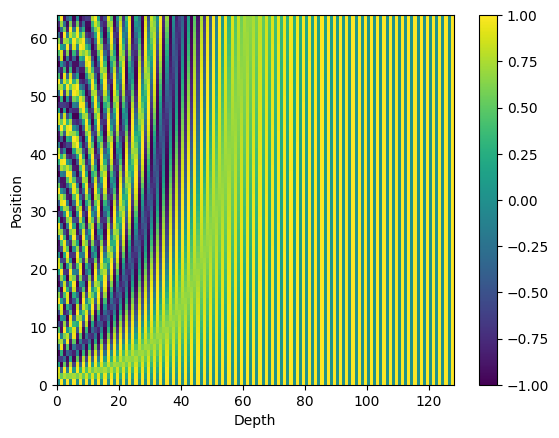

In [20]:
def plot_position_embedding(position_embedding):# 绘制位置编码
    plt.pcolormesh(position_embedding) # 绘制位置编码矩阵
    plt.xlabel('Depth')
    plt.ylabel('Position')
    plt.colorbar() # 颜色条，-1到1的颜色范围
    plt.show()

# 创建TransformerEmbedding实例并绘制位置编码
config = {
    'vocab_size': 30000,
    'd_model': 128,
    'max_length': 64,
    'pad_idx':0,
    'dropout':0.1,
}
embedding_model = TransformerEmbedding(config=config)
position_embedding_data = embedding_model.position_embedding.weight.data
plot_position_embedding(position_embedding_data)


## MultiHeadAttention(缩放点积注意力)

In [21]:
from dataclasses import dataclass


Tensor = torch.Tensor
@dataclass
class AttentionOutput:
    hidden_states: Tensor
    attn_scores: Tensor

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["d_model"]  # 隐藏层大小
        self.num_heads = config["num_heads"]  # 多头注意力的头数

        # 确保hidden_size可以被num_heads整除
        assert self.hidden_size % self.num_heads == 0, "hidden_size must be divisible by num_heads"

        # 每个头的维度,512/8=64
        self.depth = self.hidden_size // self.num_heads

        # 创建四个线性变换层
        self.Wq = nn.Linear(self.hidden_size, self.hidden_size)
        self.Wk = nn.Linear(self.hidden_size, self.hidden_size)
        self.Wv = nn.Linear(self.hidden_size, self.hidden_size)
        self.Wo = nn.Linear(self.hidden_size, self.hidden_size)

    def split_heads(self, x, batch_size):
        """
        将输入张量分割成多个头
        x shape: (batch_size, seq_len, hidden_size)
        返回 shape: (batch_size, num_heads, seq_len, depth)
        """
        # 重塑为 (batch_size, seq_len, num_heads, depth)
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        # 转置为 (batch_size, num_heads, seq_len, depth)
        return x.permute(0, 2, 1, 3)

    def merge_heads(self, x, batch_size):
        """
        将多头注意力的输出合并
        x shape: (batch_size, num_heads, seq_len, depth)
        返回 shape: (batch_size, seq_len, hidden_size)
        """
        # (batch_size, num_heads, seq_len, depth) 转置回 (batch_size, seq_len, num_heads, depth)
        x = x.permute(0, 2, 1, 3)
        # 重塑为 (batch_size, seq_len, hidden_size)
        return x.reshape(batch_size, -1, self.hidden_size)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        计算缩放点积注意力
        Q, K, V shape: (batch_size, num_heads, seq_len, depth)
        mask shape: (batch_size, 1, 1, seq_len) 或 (batch_size, 1, seq_len, seq_len)
        """
        # 计算注意力分数
        matmul_qk = torch.matmul(Q, K.transpose(-2, -1))  # (batch_size, num_heads, seq_len_q, seq_len_k)

        # 缩放
        dk = torch.tensor(self.depth, dtype=torch.float32)
        scaled_attention_logits = matmul_qk / torch.sqrt(dk)
        # print(f'scaled_attention_logits.shape:{scaled_attention_logits.shape}')
        # print(f'mask.shape{mask.shape}')
        # 应用掩码（如果提供）
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        # softmax归一化
        attention_weights = F.softmax(scaled_attention_logits, dim=-1)  # (batch_size, num_heads, seq_len_q, seq_len_k)

        # 应用注意力权重
        #(batch_size, num_heads, seq_len_q, seq_len_k) * (batch_size, num_heads, seq_len_v, depth) = (batch_size, num_heads, seq_len_q, depth)
        output = torch.matmul(attention_weights, V)  # (batch_size, num_heads, seq_len_q, depth)

        return output, attention_weights

    def forward(self, Q, K, V, mask=None):
        """
        入参Q,K,V都是X
        """
        batch_size = Q.shape[0]

        # 线性变换
        Q = self.Wq(Q)  # (batch_size, seq_len_q, hidden_size)
        K = self.Wk(K)  # (batch_size, seq_len_k, hidden_size)
        V = self.Wv(V)  # (batch_size, seq_len_v, hidden_size)

        # 分割成多头
        Q = self.split_heads(Q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        K = self.split_heads(K, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        V = self.split_heads(V, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # 计算缩放点积注意力,scaled_attention (batch_size, num_heads, seq_len_q, depth)
        # attention_weights (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        # 合并多头
        concat_attention = self.merge_heads(scaled_attention, batch_size)  # (batch_size, seq_len_q, hidden_size)

        # 最后的线性层
        output = self.Wo(concat_attention)  # (batch_size, seq_len_q, hidden_size)

        return AttentionOutput(hidden_states=output, attn_scores=attention_weights)


In [22]:
# 验证MultiHeadAttention的正向计算
import torch
import matplotlib.pyplot as plt

# 创建一个简单的测试用例
batch_size = 2
seq_len = 4
hidden_size = 8
num_heads = 2

# 创建输入张量
x = torch.randn(batch_size, seq_len, hidden_size)
print(f"输入张量形状: {x.shape}")

# 创建配置字典
config = {
    'd_model': hidden_size,
    'num_heads': num_heads
}

# 创建MultiHeadAttention实例
mha = MultiHeadAttention(config)

# 执行前向传播 (Q=K=V=x，无掩码)
output = mha(x, x, x)

# 打印结果
print(f"输出张量形状: {output.hidden_states.shape}")
print(f"注意力权重形状: {output.attn_scores.shape}")


输入张量形状: torch.Size([2, 4, 8])
输出张量形状: torch.Size([2, 4, 8])
注意力权重形状: torch.Size([2, 2, 4, 4])


In [23]:
# 验证MultiHeadAttention做交叉注意力正向计算的没问题的
import torch
import matplotlib.pyplot as plt

# 创建一个简单的测试用例
batch_size = 2
seq_len_q = 4
seq_len_kv = 6  # 不同的序列长度
hidden_size = 8
num_heads = 2

# 创建输入张量
q = torch.randn(batch_size, seq_len_q, hidden_size)
kv = torch.randn(batch_size, seq_len_kv, hidden_size)
print(f"查询张量形状: {q.shape}")
print(f"键值张量形状: {kv.shape}")

# 创建配置字典
config = {
    'd_model': hidden_size,
    'num_heads': num_heads
}

# 创建MultiHeadAttention实例
mha = MultiHeadAttention(config)

# 执行前向传播 (Q=q, K=V=kv，无掩码)
output = mha(q, kv, kv)

# 打印结果
print(f"输出张量形状: {output.hidden_states.shape}")
print(f"注意力权重形状: {output.attn_scores.shape}")


查询张量形状: torch.Size([2, 4, 8])
键值张量形状: torch.Size([2, 6, 8])
输出张量形状: torch.Size([2, 4, 8])
注意力权重形状: torch.Size([2, 2, 4, 6])


## TransformerBlock

In [24]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class TransformerBlockOutput:
    hidden_states: torch.Tensor
    self_attn_scores: torch.Tensor
    cross_attn_scores: Optional[torch.Tensor] = None

class TransformerBlock(nn.Module):
    def __init__(self, config, has_cross_attention=False):
        super().__init__()
        self.has_cross_attention = has_cross_attention
        self.d_model = config['d_model']
        self.ffn_dim = config.get('dim_feedforward', 4 * self.d_model)  # 使用配置中的ffn_dim或默认值

        # 为不同组件创建独立的dropout层
        self.self_attn_dropout = nn.Dropout(config.get('dropout', 0.1))
        self.cross_attn_dropout = nn.Dropout(config.get('dropout', 0.1))
        self.ffn_dropout = nn.Dropout(config.get('dropout', 0.1))

        # 自注意力层
        self.self_attention = MultiHeadAttention(config)
        # 层归一化
        self.self_attn_layer_norm = nn.LayerNorm(self.d_model)

        # 交叉注意力层（可选）
        if has_cross_attention:
            self.cross_attention = MultiHeadAttention(config)
            self.cross_attn_layer_norm = nn.LayerNorm(self.d_model)

        # 前馈神经网络
        self.ffn = nn.Sequential(
            nn.Linear(self.d_model, self.ffn_dim),
            nn.ReLU(),
            # nn.Dropout(config.get('dropout', 0.1)),  # FFN内部的dropout
            nn.Linear(self.ffn_dim, self.d_model)
        )
        self.ffn_layer_norm = nn.LayerNorm(self.d_model)

    def forward(self, x, encoder_output=None, self_attn_mask=None, cross_attn_mask=None):
        # 自注意力层 + dropout + 残差连接 + LayerNorm
        self_attn_output = self.self_attention(x, x, x, self_attn_mask)
        x = x + self.self_attn_dropout(self_attn_output.hidden_states)  # 使用专用的self_attn_dropout
        x = self.self_attn_layer_norm(x)

        self_attn_scores = self_attn_output.attn_scores
        cross_attn_scores = None

        # 交叉注意力层（如果有） + dropout + 残差连接 + LayerNorm
        if self.has_cross_attention and encoder_output is not None:
            cross_attn_output = self.cross_attention(x, encoder_output, encoder_output, cross_attn_mask)
            x = x + self.cross_attn_dropout(cross_attn_output.hidden_states)  # 使用专用的cross_attn_dropout
            x = self.cross_attn_layer_norm(x)
            cross_attn_scores = cross_attn_output.attn_scores

        # 前馈神经网络 + dropout + 残差连接 + LayerNorm
        ffn_output = self.ffn(x)
        x = x + self.ffn_dropout(ffn_output)  # 使用专用的ffn_dropout
        x = self.ffn_layer_norm(x)

        return TransformerBlockOutput(
            hidden_states=x,
            self_attn_scores=self_attn_scores,
            cross_attn_scores=cross_attn_scores
        )


## TransformerEncoder

In [25]:
from dataclasses import dataclass
from typing import List

import torch
from torch import Tensor
import torch.nn as nn

@dataclass
class TransformerEncoderOutput:
    last_hidden_states: Tensor
    attn_scores: List[Tensor]

class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_layers = config.get('encoder_layers', 6)

        # 创建多层Transformer编码器块
        self.layers = nn.ModuleList([
            TransformerBlock(config, has_cross_attention=False)
            for _ in range(self.num_layers)
        ])

    def forward(self, x, attention_mask=None):
        # 用于收集所有层的注意力分数
        all_attn_scores = []

        # 依次通过每个编码器层
        for layer in self.layers:
            output = layer(x, self_attn_mask=attention_mask)
            x = output.hidden_states
            all_attn_scores.append(output.self_attn_scores)

        return TransformerEncoderOutput(
            last_hidden_states=x,
            attn_scores=all_attn_scores
        )


In [26]:
def test_transformer_encoder():
    # 创建一个简单的配置
    config = {
        'encoder_layers': 2,
        'd_model': 64,
        'num_heads': 4,
        'dim_feedforward': 128,
        'dropout': 0.1,
        'max_length': 100,
        'vocab_size': vocab_size,
        'pad_idx': 0,
    }

    # 实例化模型
    encoder = TransformerEncoder(config)

    # 生成一个批次的输入
    batch_size = 2
    hidden_size = config['d_model']

    inputs_words = ["The quick brown fox jumps over the lazy dog .", "What does the fox say ?"]

    #encode变为id
    # 使用tokenizer将文本编码为token IDs
    src_sequence, src_padding_mask = tokenizer.encode([w.split() for w in inputs_words], return_mask=True)
    # 通过TransformerEmbedding处理输入序列
    src_embedded = TransformerEmbedding(config)(src_sequence)
    print(src_padding_mask.unsqueeze(1).unsqueeze(2))

    # 执行前向传播
    output = encoder(src_embedded, src_padding_mask.unsqueeze(1).unsqueeze(2))

    # 验证输出形状
    print(f"输出张量形状: {output.last_hidden_states.shape}")
    print(f"注意力层数: {len(output.attn_scores)}")
    print(f"第一层注意力分数形状: {output.attn_scores[0].shape}")

    # 检查注意力掩码是否正常工作
    # 对于被掩盖的位置，注意力分数应该很小
    print(f"第一层第二个样本的注意力分数，第9个位置是否接近0: {output.attn_scores[0][1, :, 8:].mean().item() < 0.01}")

    return output

# 运行测试
test_output = test_transformer_encoder()


tensor([[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]],


        [[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]]]])
输出张量形状: torch.Size([2, 12, 64])
注意力层数: 2
第一层注意力分数形状: torch.Size([2, 4, 12, 12])
第一层第二个样本的注意力分数，第9个位置是否接近0: False


## TransformerDecoder

In [27]:
from dataclasses import dataclass
from typing import List

@dataclass
class TransformerDecoderOutput:
    last_hidden_states: torch.Tensor
    self_attn_scores: List[torch.Tensor]
    cross_attn_scores: List[torch.Tensor]

class TransformerDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerBlock(
                config,
                has_cross_attention=True
            )
            for _ in range(config['num_decoder_layers'])
        ])
        self.dropout = nn.Dropout(config['dropout'])

    def forward(self, x, encoder_output, self_attn_mask=None, cross_attn_mask=None):
        self_attn_scores = [] # 存储每个层的自注意力分数
        cross_attn_scores = [] # 存储每个层的交叉注意力分数

        for layer in self.layers:
            layer_output = layer(
                x,
                encoder_output,
                self_attn_mask,
                cross_attn_mask
            )

            x = layer_output.hidden_states
            self_attn_scores.append(layer_output.self_attn_scores)
            cross_attn_scores.append(layer_output.cross_attn_scores)

        return TransformerDecoderOutput(
            last_hidden_states=x,
            self_attn_scores=self_attn_scores,
            cross_attn_scores=cross_attn_scores
        )


## 生成look ahead mask

In [28]:
(torch.triu(torch.ones(5, 5))==0).transpose(-1, -2)

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

Look-ahead mask for size 3:
tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

Look-ahead mask for size 5:
tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])


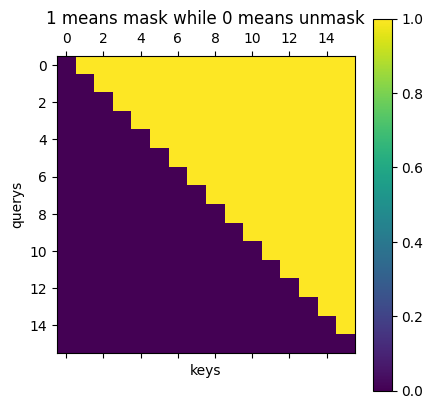

In [29]:
def generate_look_ahead_mask(size):
    """
    生成上三角掩码(look-ahead mask)，用于Transformer解码器中的自注意力机制

    Args:
        size (int): 掩码的大小 (size x size)

    Returns:
        torch.Tensor: 布尔类型的上三角掩码，其中True表示被掩盖的位置
    """
    # 创建上三角矩阵(1s在上三角，包括对角线；0s在下三角)
    mask = torch.triu(torch.ones(size, size), diagonal=1).bool()

    # 在解码器的自注意力中，我们通常掩盖未来的位置(右上方)
    # 所以需要转置使得右上方为True(被掩盖)
    return mask

# 测试不同大小的look-ahead mask
print("Look-ahead mask for size 3:")
print(generate_look_ahead_mask(3))
print("\nLook-ahead mask for size 5:")
print(generate_look_ahead_mask(5))
plt.matshow(generate_look_ahead_mask(16))
plt.colorbar()
plt.xlabel("keys")
plt.ylabel("querys")
plt.title("1 means mask while 0 means unmask")
plt.show()

['[BOS]', '[UNK]', 'quick', 'brown', '[UNK]', 'jumps', 'over', 'the', '[UNK]', 'dog', '.', '[EOS]']


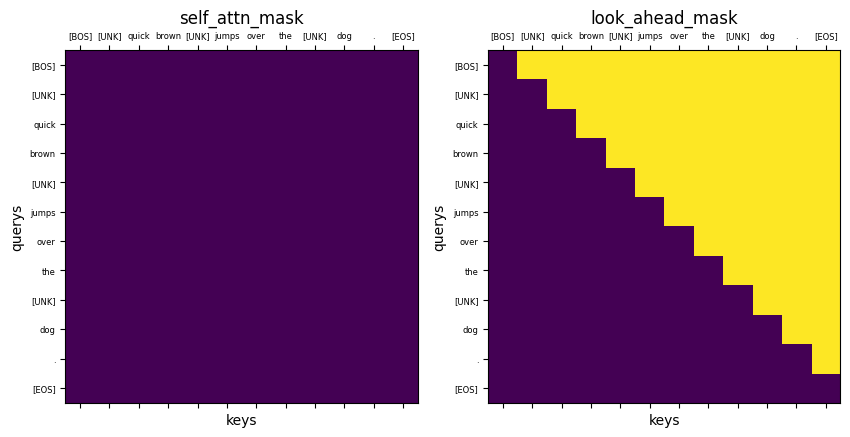

--------------------------------------------------
['[BOS]', '[UNK]', 'does', 'the', '[UNK]', 'say', '?', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


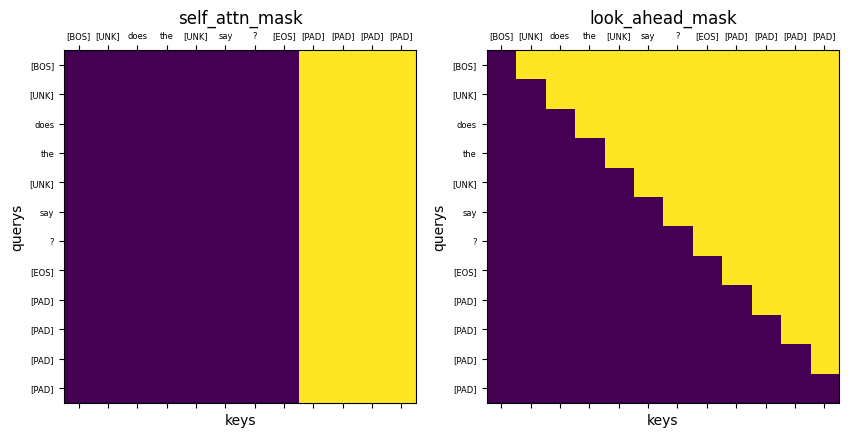

--------------------------------------------------


In [30]:
inputs_words = ["The quick brown fox jumps over the lazy dog .", "What does the fox say ?"]

#encode变为id
inputs_ids, input_padding_mask = tokenizer.encode([w.split() for w in inputs_words], return_mask=True)
for i in range(len(inputs_words)):
    decode_text = tokenizer.decode(inputs_ids[i: i+1].tolist(), remove_bos=False, remove_eos=False, remove_pad=False, split=True)[0]
    print(decode_text)
    # print(input_padding_mask[i].reshape(1, -1))
    #repeat_interleave作用：将input_padding_mask[i]重复inputs_ids.shape[-1]次，dim=0表示在第0维度上重复
    self_attn_mask  = input_padding_mask[i].reshape(1, -1).repeat_interleave(inputs_ids.shape[-1], dim=0)
    # print(input_mask[i].reshape(1, -1).repeat_interleave(inputs_ids.shape[-1], dim=0))
    look_ahead_mask = generate_look_ahead_mask(inputs_ids.shape[-1])

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].matshow(self_attn_mask)
    axs[0].set_title("self_attn_mask")
    axs[0].set_yticks(range(len(decode_text)), decode_text, fontsize=6)
    axs[0].set_ylabel("querys")
    axs[0].set_xticks(range(len(decode_text)), decode_text, fontsize=6)
    axs[0].set_xlabel("keys")
    axs[1].matshow(look_ahead_mask)
    axs[1].set_title("look_ahead_mask")
    axs[1].set_yticks(range(len(decode_text)), decode_text, fontsize=6)
    axs[1].set_ylabel("querys")
    axs[1].set_xticks(range(len(decode_text)), decode_text, fontsize=6)
    axs[1].set_xlabel("keys")
    plt.show()
    print('-'*50)

## TransformerModel

In [31]:
from dataclasses import dataclass
from typing import Optional, List, Dict, Any, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import time


@dataclass
class TransformerOutput:
    logits: torch.Tensor
    encoder_attentions: Optional[List[torch.Tensor]] = None
    decoder_attentions: Optional[List[torch.Tensor]] = None
    cross_attentions: Optional[List[torch.Tensor]] = None
    preds: Optional[torch.Tensor] = None


class TransformerModel(nn.Module):
    def __init__(self, config: Dict[str, Any]):
        super().__init__()
        self.d_model = config.get("d_model", 512)
        self.num_heads = config.get("num_heads", 8)
        self.pad_token_id = config.get("pad_token_id", 0)
        self.pad_idx = config.get("pad_idx", 0)
        self.vocab_size = config.get("vocab_size")
        self.share_embeddings = config.get("share_embeddings", False)
        self.max_length=config['max_length']
        self.bos_idx = config["bos_idx"]
        self.eos_idx = config["eos_idx"]
        # Embedding layers using TransformerEmbedding
        self.src_embedding = TransformerEmbedding(config=config)

        if self.share_embeddings:
            self.tgt_embedding = self.src_embedding
            # Share embedding weights with output projection layer
            self.output_projection = lambda x: torch.matmul(
                x, self.tgt_embedding.get_word_embedding_weights().T
            )  # 输出层，共享参数，直接拿原有embedding矩阵的转置，节省内存
        else:
            self.tgt_embedding = TransformerEmbedding(config=config)
            self.output_projection = nn.Linear(self.d_model, self.vocab_size)

        # Encoder and Decoder
        self.encoder = TransformerEncoder(config=config)

        self.decoder = TransformerDecoder(config=config)

        # Initialize parameters with Xavier uniform
        self._init_parameters()

    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(
        self,
        src_inputs: torch.Tensor,
        tgt_inputs: torch.Tensor,
        src_padding_mask: Optional[torch.Tensor] = None,
        tgt_padding_mask: Optional[torch.Tensor] = None,
    ) -> TransformerOutput:
        batch_size, src_seq_len = src_inputs.size()
        bs, tgt_seq_len = tgt_inputs.size()

        # Create masks if not provided，实际是一定会传的，shape从[batch_size,src_seq_len]变为[batch_size,1,1,src_seq_len]
        src_padding_mask = src_padding_mask.unsqueeze(1).unsqueeze(2)

        if tgt_padding_mask is None:
            tgt_padding_mask = tgt_inputs == self.pad_token_id

        # Create look-ahead mask for decoder
        look_ahead_mask = generate_look_ahead_mask(tgt_seq_len).to(tgt_inputs.device)

        # print(f"tgt_padding_mask.shape:{tgt_padding_mask.shape}")
        # 合并decoder_inputs的padding_mask和look_ahead_mask,shape变为[batch_size,tgt_seq_len,tgt_seq_len]
        combined_mask = torch.max(
            tgt_padding_mask.unsqueeze(1).repeat(1, tgt_seq_len, 1), look_ahead_mask
        )
        combined_mask = combined_mask.unsqueeze(
            1
        )  # 变为[batch_size, 1, tgt_seq_len, tgt_seq_len]
        # print(f"combined_mask.shape:{combined_mask.shape}")

        # Embeddings
        src_embedded = self.src_embedding(src_inputs)
        tgt_embedded = self.tgt_embedding(tgt_inputs)

        # 编码器模块计算
        encoder_output = self.encoder(src_embedded, attention_mask=src_padding_mask)
        # print(f"src_padding_mask.shape:{src_padding_mask.shape}")
        # print(f"combined_mask.shape:{combined_mask.shape}")
        # 解码器模块计算
        decoder_output = self.decoder(
            tgt_embedded,
            encoder_output.last_hidden_states,
            self_attn_mask=combined_mask,
            cross_attn_mask=src_padding_mask,  # 交叉注意力mask
        )

        # 分类层
        logits = self.output_projection(decoder_output.last_hidden_states)

        return TransformerOutput(
            logits=logits,
            encoder_attentions=encoder_output.attn_scores,
            decoder_attentions=decoder_output.self_attn_scores,
            cross_attentions=decoder_output.cross_attn_scores,
        )

    @torch.no_grad()
    def infer(self, encoder_inputs, encoder_inputs_mask=None):
        if encoder_inputs_mask is None:  # 应对多个样本同时进行推理
            encoder_inputs_mask = encoder_inputs.eq(self.pad_idx)
        encoder_inputs_mask = encoder_inputs_mask.unsqueeze(1).unsqueeze(
            2
        )  # [batch_size, 1, 1, src_len],[1,src_len]相加时，会自动广播到[batch_size,1,src_len,src_len]
        look_ahead_mask = generate_look_ahead_mask(self.max_length)
        look_ahead_mask = (
            look_ahead_mask.unsqueeze(0).unsqueeze(0).to(encoder_inputs.device)
        )  # [1, 1, trg_len, trg_len]

        # 做embedding
        encoder_inputs_embeds = self.src_embedding(encoder_inputs)
        encoder_outputs = self.encoder(
            encoder_inputs_embeds,
            encoder_inputs_mask
        )
        # 解码器模块计算
        decoder_inputs = torch.Tensor([self.bos_idx] * encoder_inputs.shape[0]).reshape(-1, 1).long().to(device=encoder_inputs.device)
        for cur_len in tqdm(range(1, self.max_length + 1)):
            # 做decoder的embedding
            decoder_inputs_embeds = self.tgt_embedding(decoder_inputs)
            decoder_outputs = self.decoder(
                decoder_inputs_embeds,
                encoder_outputs.last_hidden_states,
                look_ahead_mask[:, :, :cur_len, :cur_len],#decoder的自注意力mask
                encoder_inputs_mask
            )

            logits = self.output_projection(decoder_outputs.last_hidden_states)  # (batch_size, trg_len, vocab_size)
            next_token = logits.argmax(dim=-1)[:, -1:] #通过最大下标确定类别，[:, -1:]表示取最后一个结果
            decoder_inputs = torch.cat([decoder_inputs, next_token], dim=-1) #预测输出拼接到输入中
            #(decoder_inputs == self.eos_idx).sum(dim=-1)是判断样本中是否含有EOS标记
            #all是每一个都为True，才会结束
            if all((decoder_inputs == self.eos_idx).sum(dim=-1) > 0):
                break
        return TransformerOutput(
            preds=decoder_inputs[:, 1:],
            logits=logits,
            encoder_attentions=encoder_outputs.attn_scores,
            decoder_attentions=decoder_outputs.self_attn_scores,
            cross_attentions=decoder_outputs.cross_attn_scores,
        )

# 损失函数

In [32]:
class CrossEntropyWithPadding:
    def __init__(self, config):
        self.label_smoothing = config["label_smoothing"]

    def __call__(self, logits, labels, padding_mask=None):
        # logits.shape = [batch size, sequence length, num of classes]
        # labels.shape = [batch size, sequence length]
        # padding_mask.shape = [batch size, sequence length]，decode_label_mask
        bs, seq_len, nc = logits.shape
        loss = F.cross_entropy(logits.reshape(bs * seq_len, nc), labels.reshape(-1), reduce=False, label_smoothing=self.label_smoothing) #label_smoothing表示随机将一个类别的概率设置为0.1，使得模型更加关注其他类别
        if padding_mask is None:
            loss = loss.mean()
        else:
            padding_mask = 1 - padding_mask.reshape(-1) #将padding_mask reshape成一维张量，mask部分为0，非mask部分为1
            loss = torch.mul(loss, padding_mask).sum() / padding_mask.sum()

        return loss


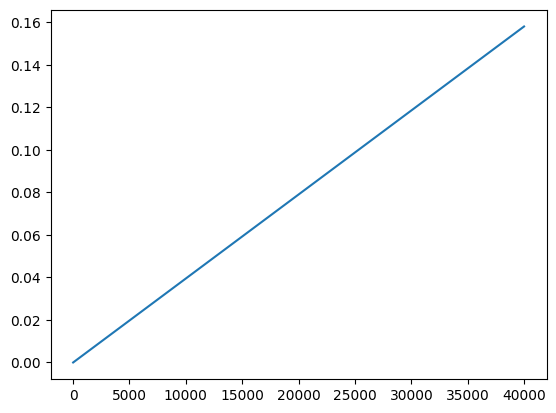

In [33]:
x=np.arange(1, 40000)
plt.plot(x, x * (4000 ** (-1.5)))

# Warmup技术

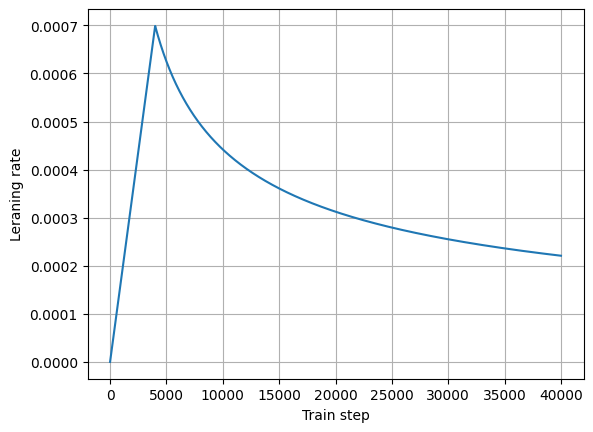

In [34]:
# NoamDecayScheduler 是一个自定义或外部定义的学习率衰减调度器类。它需要接收配置 config 作为参数，可能实现了特定的学习率衰减方案
class NoamDecayScheduler:
    def __init__(self, config):
        self.d_model = config["d_model"]  # 获取模型的维度大小
        self.warmup_steps = config["warmup_steps"]  # 获取预热步数

    def __call__(self, step):
        step += 1  # 步数从1开始计算，而不是0
        arg1 = step ** (-0.5)  # 4000步之后是arg1，计算步数的-0.5次方
        arg2 = step * (self.warmup_steps ** (-1.5))  # 4000步之前是arg2，计算步数乘以预热步数的-1.5次方

        arg3 = self.d_model ** (-0.5)  # 计算模型维度的-0.5次方

        return arg3 * np.minimum(arg1, arg2)  # 返回学习率，取arg1和arg2的较小值乘以arg3


temp_learning_rate_schedule = NoamDecayScheduler({"d_model": 512, "warmup_steps": 4000})  # 创建学习率调度器实例，设置模型维度为512，预热步数为4000
#下面是学习率的设计图
plt.plot(temp_learning_rate_schedule(np.arange(0, 40000)))  # 绘制学习率曲线，横轴为0到40000的步数
plt.ylabel("Leraning rate")  # 设置y轴标签为"学习率"
plt.xlabel("Train step")  # 设置x轴标签为"训练步数"
plt.grid()  # 显示网格线
plt.show()  # 显示图表


In [35]:
from torch.optim.lr_scheduler import LambdaLR
from torch.optim import Adam

def get_optimizer(model, config):
    base_lr = config['base_lr']
    beta1 = config["beta1"] # Adam 的 beta1
    beta2 = config["beta2"] # Adam 的 beta2
    eps = config["eps"] # Adam 的 eps，防止分母为0
    optimizer = Adam(model.parameters(), lr=base_lr, betas=(beta1, beta2), eps=eps)
    lr_scheduler1 = NoamDecayScheduler(config) #config是一个字典，包含了学习率衰减的参数
    # 使用 LambdaLR 调度器，它可以根据给定的函数 lr_lambda 调整学习率。这里将 lr_scheduler 作为函数传递给 LambdaLR，它包含了特定于模型或任务的学习率调度规则
    scheduler = LambdaLR(optimizer, lr_lambda=lr_scheduler1)
    return optimizer, scheduler

# 保存模型，早停

In [36]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch.
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = - np.inf

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [37]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = - np.inf
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience


# 评估，训练

In [38]:
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for batch in dataloader:
        encoder_inputs = batch["encoder_inputs"]
        encoder_inputs_mask = batch["encoder_inputs_mask"]
        decoder_inputs = batch["decoder_inputs"]
        decoder_labels = batch["decoder_labels"]
        decoder_labels_mask = batch["decoder_labels_mask"]

        # 前向计算
        outputs = model(
            encoder_inputs,
            decoder_inputs,
            encoder_inputs_mask
            )
        logits = outputs.logits
        loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)         # 验证集损失
        loss_list.append(loss.cpu().item())

    return np.mean(loss_list)


In [39]:
# 训练
def training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    scheduler=None,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 1
    val_loss = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for batch in train_loader:
                encoder_inputs = batch["encoder_inputs"]
                encoder_inputs_mask = batch["encoder_inputs_mask"]
                decoder_inputs = batch["decoder_inputs"]
                decoder_labels = batch["decoder_labels"]
                decoder_labels_mask = batch["decoder_labels_mask"]
                # 梯度清空
                optimizer.zero_grad()

                # 前向计算
                outputs = model(
                    encoder_inputs,
                    decoder_inputs,
                    encoder_inputs_mask
                    )
                logits = outputs.logits
                loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)

                # 梯度回传
                loss.backward()

                # 调整优化器，包括学习率的变动等
                optimizer.step()
                if scheduler is not None:
                    scheduler.step() # 更新学习率,学习率就会传递给optimizer

                loss = loss.cpu().item()
                # record
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train()

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=-val_loss)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id, "loss": loss, "val_loss": val_loss})

    return record_dict


# 开始训练

In [40]:
#模型的超参
config = {
    "bos_idx": 1,
    "eos_idx": 3,
    "pad_idx": 0,
    "vocab_size": len(word2idx),
    "max_length": 128,#seq_len最大长度
    "d_model": 512,#可以调整
    "dim_feedforward": 2048, # FFN 的隐藏层大小
    "dropout": 0.1,#可以调整
    "layer_norm_eps": 1e-6, # 层归一化的 epsilon, 防止除零错误
    "num_heads": 8,#论文里是8，可以调整
    "num_decoder_layers": 6, #论文是6，可以调整
    "num_encoder_layers": 6, #论文是6，可以调整
    "label_smoothing": 0.1,#标签平滑，防止过拟合
    "beta1": 0.9, # Adam 的 beta1
    "beta2": 0.98,
    "eps": 1e-9, # Adam 的 epsilon
    "warmup_steps": 4000,
    "share_embedding": False, # 是否共享词向量，如果改为True，效果不好
    "base_lr": 0.1,
    }

# 数据加载器
def get_dl(dataset, batch_size, shuffle=True):
    sampler = TransformerBatchSampler(dataset, batch_size=batch_size, shuffle_batch=shuffle)
    sample_dl = DataLoader(dataset, batch_sampler=sampler, collate_fn=partial(collate_fct, tokenizer=tokenizer))
    return sample_dl

# dataset
train_ds = LangPairDataset("train", max_length=config["max_length"])
val_ds = LangPairDataset("val", max_length=config["max_length"])
# tokenizer
tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word, max_length=config["max_length"])
batch_size = 4096
# dataloader
train_dl = get_dl(train_ds, batch_size=batch_size, shuffle=True)
val_dl = get_dl(val_ds, batch_size=batch_size, shuffle=False)

save cache to wmt16/.cache/de2en_train_128.npy
save cache to wmt16/.cache/de2en_val_128.npy


In [41]:
len(train_dl)*20

140

In [42]:

epoch = 20

# model
model = TransformerModel(config)
# 计算模型参数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"模型总参数量: {total_params:,}")



# 1. 定义损失函数 采用交叉熵损失
loss_fct = CrossEntropyWithPadding(config)
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer, scheduler = get_optimizer(model, config)

if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(
    f"checkpoints", save_step=500, save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=8)

model = model.to(device)

record = training(
    model,
    train_dl,
    val_dl,
    epoch,
    loss_fct,
    optimizer,
    scheduler,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=None,
    eval_step=500
    )

模型总参数量: 71,975,103


  0%|          | 0/140 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
10540it [17:26, 10.07it/s, epoch=19, loss=3.55, val_loss=3.56]                   


In [43]:
from nltk.translate.bleu_score import sentence_bleu
# load checkpoints
model = TransformerModel(config) #初始化模型
state_dict = torch.load("checkpoints/best.ckpt")
model.load_state_dict(state_dict)

loss_fct = CrossEntropyWithPadding(config)
# from dataset import LangPairDataset
test_ds = LangPairDataset("test", max_length=128, data_dir="./wmt16")
test_dl = DataLoader(test_ds, batch_size=1, collate_fn=partial(collate_fct, tokenizer=tokenizer))

model = model.to(device)
model.eval()
collect = {}
loss_collect = []

predictions = []
answers = []
# 初始化BLEU分数列表
bleu_scores = []
for idx, batch in tqdm(enumerate(test_dl)):
    encoder_inputs = batch["encoder_inputs"]
    encoder_inputs_mask = batch["encoder_inputs_mask"]
    decoder_inputs = batch["decoder_inputs"]
    decoder_labels = batch["decoder_labels"]
    # print(decoder_labels.cpu())
    # decoder_labels1=tokenizer.decode(decoder_labels.cpu().numpy())
    # print(decoder_labels1)
    # 前向计算
    outputs = model(
        encoder_inputs,
        decoder_inputs,
        encoder_inputs_mask
        )
    loss = loss_fct(outputs.logits, decoder_labels)         # 测试集损失，如果batch_size不为1，需要加入mask

    # print(outputs.logits.shape, decoder_labels.shape)

    # loss = loss_fct(outputs.logits[:, :decoder_labels.shape[1]], decoder_labels)         # 验证集损失
    # outputs = model.infer(encoder_inputs=encoder_inputs)
    # print(outputs.logits.shape)
    preds = outputs.logits.argmax(dim=-1) # 预测结果，[1,seq_len]
    # print(preds.shape)
    #把preds转为英文单词
    preds = tokenizer.decode(preds.cpu().numpy()) #['预测句子']
    # predictions.append(preds)
    # print(preds)
    #把decoder_labels转为英文单词
    decoder_labels = tokenizer.decode(decoder_labels.cpu().numpy()) #['标签句子']
    # answers.append(decoder_labels)
    # print(decoder_labels)
    belu=sentence_bleu([decoder_labels[0].split()],preds[0].split(),weights=(1, 0, 0, 0))
    bleu_scores.append(belu)
    collect[idx] = {"loss": loss.item(), "src_inputs": encoder_inputs, "trg_inputs": decoder_inputs, "mask": encoder_inputs_mask, "trg_labels": decoder_labels, "preds": preds}
    loss_collect.append(loss.item())
    # break

# sort collect by value
collect = sorted(collect.items(), key=lambda x: x[1]["loss"])
print(f"testing loss: {np.array(loss_collect).mean()}")
sum(bleu_scores) / len(bleu_scores)

save cache to wmt16/.cache/de2en_test_128.npy


0it [00:00, ?it/s]/opt/conda/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
4it [00:00, 33.47it/s]/opt/conda/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
19it [00:00, 40.37it/s]/opt/conda/lib/python3.11/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using 

testing loss: 3.4483396861370554


0.5527467552973392

# 翻译

In [44]:
!pip install Cython  # if failed to install fastBPE, try this line
!pip install fastBPE #分词使用，分词直接在内存中进行，无需把数据写入文件，用subword-nmt命令

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


Loading vocabulary from ./wmt16/vocab ...
Read 762259 words (18107 unique) from vocabulary file.
Loading codes from ./wmt16/bpe.20000 ...
Read 20001 codes from the codes file.


[['ein', 'mann', 'mit', 'einem', 'eimer', 'und', 'ein', 'mädchen', 'mit', 'einem', 'hut', 'am', 'strand', '.']]


 11%|█         | 14/128 [00:00<00:02, 41.58it/s]
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


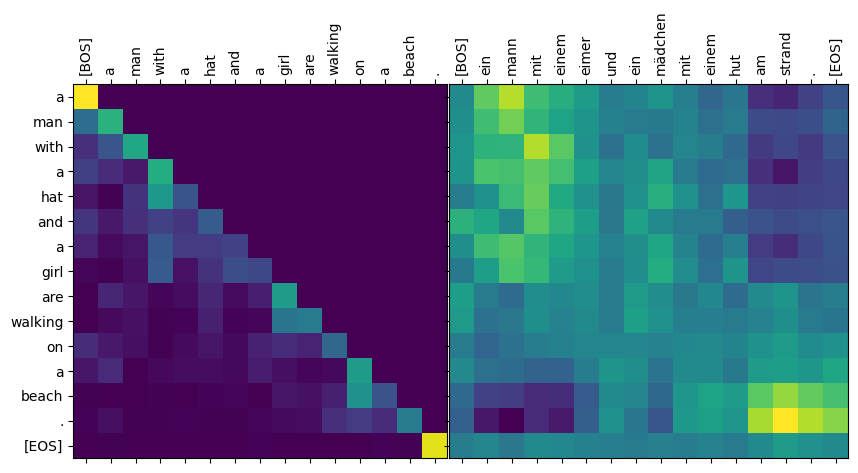

['a man with a hat and a girl are walking on a beach.']

In [45]:

# 在 Windows 系统上并没有 sys/mman.h 文件，windows上无法安装fastBPE
import re
from fastBPE import fastBPE
from sacremoses import MosesDetokenizer, MosesTokenizer

# `MosesTokenizer` 和 `MosesDetokenizer` 是来自 `sacremoses` 库的工具，用于自然语言处理中的分词（Tokenization）和去标记化（Detokenization）。这些工具主要用于对文本进行预处理和后处理，通常在处理自然语言处理任务时会用到。
#
# ### MosesTokenizer：
# - **作用**：将原始文本分割成单词和标点符号。
# - **特点**：基于 Moses 翻译工具中使用的分词方法。
# - **功能**：
#   - 将句子分割成单词和标点符号。
#   - 处理缩写、连字符、标点等特殊情况。
#   - 对文本进行标记化，方便后续处理。
#
# ### MosesDetokenizer：
# - **作用**：将分词后的文本重新组合成原始的句子。
# - **特点**：用于对分词后的文本进行还原，使其恢复为可读的句子形式。
# - **功能**：
#   - 将分词后的单词和标点符号重新组合成句子。
#   - 处理分词后的标点、缩写等情况，使得结果更加自然和可读。
#
# 这些工具通常在文本预处理和后处理过程中使用，对输入的文本进行标记化和去标记化，是一种常用的处理方式。在自然语言处理任务中，对文本进行正确的分词和还原是很重要的，而 `MosesTokenizer` 和 `MosesDetokenizer` 提供了方便、高效的工具来处理这些任务。

class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        self.bpe = fastBPE("./wmt16/bpe.20000", "./wmt16/vocab") #如果bpe.20000名字变了，这里要改
        self.mose_tokenizer = MosesTokenizer(lang="de") # 德语分词器，如果是其他语言，这里要改
        self.mose_detokenizer = MosesDetokenizer(lang="en") # 英语去标记化器，如果是其他语言，这里要改
        self.model = model # 模型
        self.model.eval() # 设置为评估模式
        self.src_tokenizer = src_tokenizer # 源语言分词器
        self.trg_tokenizer = trg_tokenizer # 目标语言分词器
        self.pattern = re.compile(r'(@@ )|(@@ ?$)') # 正则表达式，用于去除分词器添加的特殊标记,匹配 @@ ?$​ 出现在字符串末尾，可选后跟一个空格（?表示0或1次）

    def draw_attention_map(self, attn_scores, cross_attn_scores, src_words_list, trg_words_list):
        """绘制注意力热力图
        attn_scores (numpy.ndarray): 表示自注意力机制（self-attention）分数。
        cross_attn_scores (numpy.ndarray): 表示交叉注意力机制的注意力分数。
        src_words_list (list): 源语言句子的单词列表。
        trg_words_list (list): 目标语言句子的单词列表。
        """
        assert len(attn_scores.shape) == 3, "attn_scores shape should be " \
            f"[num heads, target sequence length, target sequence length], but got {attn_scores.shape}"
        attn_scores = attn_scores[:, :len(trg_words_list), :len(trg_words_list)]

        assert len(cross_attn_scores.shape) == 3, "attn_scores shape should be " \
            f"[num heads, target sequence length, source sequence length], but got {cross_attn_scores.shape}"
        cross_attn_scores = cross_attn_scores[:, :len(trg_words_list), :len(src_words_list)]

        num_heads, trg_len, src_len = cross_attn_scores.shape

        fig = plt.figure(figsize=(10, 5), constrained_layout=True) # constrained_layout=True 自动调整子图参数，使之填充整个图像区域
        grid = plt.GridSpec(trg_len, trg_len + src_len, wspace=0.1, hspace=0.1)# wspace,hspace 控制子图之间的间距
        #下面是attn_scores的热力图
        self_map = fig.add_subplot(grid[:,:trg_len]) #  添加子图
        self_map.matshow(attn_scores.mean(dim=0), cmap='viridis') # 绘制热力图，cmap表示颜色,dim=0表示对第0维求均值
        self_map.set_yticks(range(trg_len), trg_words_list, fontsize=10)
        self_map.set_xticks(range(trg_len), ["[BOS]"] + trg_words_list[:-1], rotation=90)
        #下面是cross_attn_scores的热力图
        cross_map = fig.add_subplot(grid[:, trg_len:])
        cross_map.matshow(cross_attn_scores.mean(dim=0), cmap='viridis')
        cross_map.set_yticks(range(trg_len), [], fontsize=6)
        cross_map.set_xticks(range(src_len), src_words_list, rotation=90)

        plt.show()

    def draw_attention_maps(self, attn_scores, cross_attn_scores, src_words_list, trg_words_list, heads_list):
        """绘制注意力热力图

        Args:
            - scores (numpy.ndarray): shape = [source sequence length, target sequence length]
        """
        assert len(attn_scores.shape) == 3, "attn_scores shape should be " \
            f"[num heads, target sequence length, target sequence length], but got {attn_scores.shape}"
        attn_scores = attn_scores[:, :len(trg_words_list), :len(trg_words_list)]

        assert len(cross_attn_scores.shape) == 3, "attn_scores shape should be " \
            f"[num heads, target sequence length, source sequence length], but got {cross_attn_scores.shape}"
        cross_attn_scores = cross_attn_scores[:, :len(trg_words_list), :len(src_words_list)]
        # cross_attn_scores = cross_attn_scores[:, :len(src_words_list), :len(src_words_list)]

        num_heads, trg_len, src_len = cross_attn_scores.shape
        fig, axes = plt.subplots(2, len(heads_list), figsize=(5 * len(heads_list), 10))
        for i, heads_idx in enumerate(heads_list):
            axes[0, i].matshow(attn_scores[heads_idx], cmap='viridis')
            axes[0, i].set_yticks(range(trg_len), trg_words_list)
            axes[0, i].set_xticks(range(trg_len), ["[BOS]"] + trg_words_list[:-1], rotation=90)
            axes[0, i].set_title(f"head {heads_idx}")
            axes[1, i].matshow(cross_attn_scores[heads_idx], cmap='viridis')
            axes[1, i].set_yticks(range(trg_len), trg_words_list)
            axes[1, i].set_xticks(range(src_len), src_words_list, rotation=90)
            axes[1, i].set_title(f"head {heads_idx}")

        plt.show()


    def __call__(self, sentence_list, heads_list=None, layer_idx=-1):
        # 将输入句子列表转换为小写，并使用 MosesTokenizer 进行分词处理。
        sentence_list = [" ".join(self.mose_tokenizer.tokenize(s.lower())) for s in sentence_list]
        # 将分词后的结果进行 BPE 编码，得到 tokens_list。
        tokens_list = [s.split() for s in self.bpe.apply(sentence_list)]
        print(tokens_list)
        # 使用 src_tokenizer 对 tokens_list 进行编码，同时添加起始标记 ([BOS]) 和结束标记 ([EOS])。
        encoder_input, attn_mask = self.src_tokenizer.encode(
            tokens_list,
            add_bos=True,
            add_eos=True,
            return_mask=True,
            )
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64)
        # 使用模型的 infer 方法对编码器输入进行推理，得到输出结果 outputs
        outputs = model.infer(encoder_inputs=encoder_input, encoder_inputs_mask=attn_mask)

        preds = outputs.preds.numpy()
        # 使用目标语言的 trg_tokenizer 对预测序列进行解码，得到解码后的目标语言句子列表 trg_decoded。
        trg_decoded = self.trg_tokenizer.decode(preds, split=True, remove_eos=False, remove_bos=False, remove_pad=False)
        # 使用源语言的 src_tokenizer 对编码器输入进行解码，得到解码后的源语言句子列表 src_decoded。为下面绘制热力图做准备。
        src_decoded = self.src_tokenizer.decode(
            encoder_input.numpy(),
            split=True,
            remove_bos=False,
            remove_eos=False
            )

        # post processed attn scores
        # outputs.decoder_attentions[-1]  # the last layer of self-attention scores

        # draw the attention map of the last decoder block
        for attn_score, cross_attn_score, src, trg in zip(
            outputs.decoder_attentions[layer_idx], outputs.cross_attentions[layer_idx], src_decoded, trg_decoded):
            if heads_list is None:# 如果没有指定heads_list，就画单个热力图
                self.draw_attention_map(
                    attn_score,
                    cross_attn_score,
                    src,
                    trg,
                )
            else:# 如果指定了heads_list，就画多个热力图
                self.draw_attention_maps(
                    attn_score,
                    cross_attn_score,
                    src,
                    trg,
                    heads_list=heads_list,
                    )
        return [self.mose_detokenizer.tokenize(self.pattern.sub("", s).split()) for s in self.trg_tokenizer.decode(preds)] #将解码后的目标语言句子列表返回，并使用 mose_detokenizer 进行去标记化，最终得到翻译后的结果。


# sentence_list = [
#     "Mann in einem kleinen weißen Boot auf einem See.",  # Man in a small white boat on a lake.
#     "Ein Mann mit einem Eimer und ein Mädchen mit einem Hut am Strand.", # A man with a bucket and a girl in a hat on the beach.
#     "Drei Männer auf Pferden während eines Rennens.",  # Three men on horses during a race.
#     "Ein Mann und eine Frau essen zu Abend",  # 一个男人和一个女人在吃晚餐
# ]
sentence_list = [
    # "Mann in einem kleinen weißen Boot auf einem See.",  # Man in a small white boat on a lake.
    "Ein Mann mit einem Eimer und ein Mädchen mit einem Hut am Strand.", # A man with a bucket and a girl in a hat on the beach.
    # "Drei Männer auf Pferden während eines Rennens.",  # Three men on horses during a race.
    # "Ein Mann und eine Frau essen zu Abend",  # 一个男人和一个女人在吃晚餐
]

# load checkpoints
model = TransformerModel(config)
model.load_state_dict(state_dict)
translator = Translator(model.cpu(), tokenizer, tokenizer)
translator(
    sentence_list,
    layer_idx=-1,
    # heads_list=[0, 1, 2, 3, 4, 5, 6, 7]
    )
